In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os
import json
import re

In [2]:
def get_frame_id(path):
    path = os.path.basename(path)
    return re.findall(r'[0-9][0-9][0-9][0-9][0-9]',path)[0]

In [3]:
valid_set = [get_frame_id(path) for path in sorted(list(glob.glob('/mnt/home/tchan1/ceph/preped-npy/valid-out/*rhop.npy')))]

In [4]:
def format_json(json, formatter):
    for key, val in json.items():
        if key in formatter.keys():
            json[key] = formatter[key](val)
    return json

In [5]:
def get_valid_rdf(path,valid_set):
    path = sorted(list(glob.glob(path)))[0]
    with open(path,'r') as json_file:
        #print(json.load(json_file))
        valid_subset = [frame for frame in json.load(json_file) if get_frame_id(frame['rho-path']) in valid_set]
        for entry in valid_subset:
            formatter = {
                        'binEdges':np.array,
                        'binCenters':np.array,
                        'DCF': np.array,
                        'RDF': np.array
                    }
            format_json(entry,formatter)
    return valid_subset


In [6]:
def get_valid_vrel(path, valid_set):
    paths = sorted(list(glob.glob(path)))
    #print(paths)
    vrel_list = []
    for path in paths:
        with open(path,'r') as json_file:
            frame = json.load(json_file)
            if get_frame_id(frame['rhop-path']) in valid_set:
                formatter = {
                    'binEdges':np.array,
                    'binCenters':np.array,
                    'velc_sum': np.array,
                    'velc_rad_sum': np.array
                }
                format_json(frame,formatter)
                vrel_list.append(frame)
    return vrel_list

In [7]:
def get_rdf_fluctuation(rdf_list,list_mode=False,with_qunatiles=False):
    assert len(rdf_list) >= 1
    rdf_items = []
    for rdf in rdf_list:
        rdf_items.append(rdf['RDF'])
    stacked_rdf = np.stack(rdf_items)
    rdf_mean = np.mean(stacked_rdf,axis=0)
    rdf_var  = np.var(stacked_rdf,axis=0)
    q1,q3 = np.quantile(stacked_rdf,[0.25,0.75],axis=0)
    binCenters = [rdf['binCenters']]*len(rdf_items) if list_mode else rdf['binCenters']
    
    return {
        'binCenters':binCenters,
        'items': rdf_items,
        'mean': rdf_mean,
        'var': rdf_var,
        'q1':q1,
        'q3':q3
    }

In [8]:
def get_velc_fluctuation(velc_list, list_mode=False):
    assert len(velc_list) >= 1
    velc_items = []
    rad_items  = []
    for velc in velc_list:
        velc_items.append(velc['velc_sum'])
        rad_items.append(velc['velc_rad_sum'])
    stacked_velc = np.stack(velc_items)
    stacked_rad  = np.stack(rad_items)
    velc_median  = np.median(stacked_velc,axis=0)
    rad_median   = np.median(stacked_rad, axis=0)
    velc_var     = np.var(stacked_velc,axis=0)
    rad_var      = np.var(stacked_rad, axis=0)
    velc_q1, velc_q3 = np.quantile(stacked_velc,[0.25,0.75],axis=0)
    rad_q1,  rad_q3  = np.quantile(stacked_rad, [0.25,0.75],axis=0)
    binCenters = [velc['binCenters']]*len(velc_items) if list_mode else velc['binCenters']
    
    return {
        'binCenters':binCenters,
        'velc_items': velc_items,
        'rad_items': rad_items,
        'velc_mean': velc_median,
        'rad_mean': rad_median,
        'velc_var': velc_var,
        'rad_var': rad_var,
        'velc_q1': velc_q1, 'velc_q3':velc_q3,
        'rad_q1' : rad_q1,  'rad_q3': rad_q3
    }
    

In [9]:
def get_rdf_ratio_fluctuation(out_rdfs, tgt_rdfs):
    sorted_tgt = sorted(tgt_rdfs,key=lambda d: d['rho-path'])
    sorted_out = sorted(out_rdfs,key=lambda d: d['rho-path'])
    tgt_rdfs = [frame['RDF'] for frame in sorted_tgt]
    out_rdfs = [frame['RDF'] for frame in sorted_out]
    stack_tgt = np.stack(tgt_rdfs)
    stack_out = np.stack(out_rdfs)
    
    stack_ratio = stack_out/stack_tgt
    ratio_median = np.mean(stack_ratio, axis=0)
    ratio_var    = np.var(stack_ratio,axis=0)
    ratio_q1, ratio_q3 = np.quantile(stack_ratio,[0.25,0.75],axis=0)
    
    return {
        'binCenters':sorted_tgt[0]['binCenters'],
        'ratio_mean': ratio_median,
        'ratio_q1':ratio_q1,
        'ratio_q3':ratio_q3
    }

In [10]:
def get_vel_ratio_fluctuation(out_vrel,tgt_vrel):
    sorted_tgt = sorted(tgt_vrel,key=lambda d: d['rhop-path'])
    sorted_out = sorted(out_vrel,key=lambda d: d['rhop-path'])
    
    tgt_vel = [frame['velc_sum'] for frame in sorted_tgt]
    out_vel = [frame['velc_sum'] for frame in sorted_out]
    tgt_rad = [frame['velc_rad_sum'] for frame in sorted_tgt]
    out_rad = [frame['velc_rad_sum'] for frame in sorted_out]
    
    stack_tgt_vel = np.stack(tgt_vel)
    stack_out_vel = np.stack(out_vel)
    stack_tgt_rad = np.stack(tgt_rad)
    stack_out_rad = np.stack(out_rad)
    
    stack_ratio_vel = stack_out_vel/stack_tgt_vel
    stack_ratio_rad = stack_out_rad/stack_tgt_rad
    
    vel_median = np.median(stack_ratio_vel, axis=0)
    rad_median = np.median(stack_ratio_rad, axis=0)
    
    vel_q1, vel_q3 = np.quantile(stack_ratio_vel,[0.25,0.75],axis=0)
    rad_q1, rad_q3 = np.quantile(stack_ratio_rad,[0.25,0.75],axis=0)
    
    return {
        'binCenters':sorted_tgt[0]['binCenters'],
        'vel_mean': vel_median,
        'rad_mean': rad_median,
        'vel_q1':vel_q1,'vel_q3':vel_q3,
        'rad_q1':rad_q1,'rad_q3':rad_q3
    }
    

In [11]:
def get_frame(array, frame_id):
    for item in array:
        if get_frame_id(item['rho-path']) == frame_id:
            return item.copy()

In [12]:
valid_tgt_rdfs = get_valid_rdf('tgt-normal*.json',valid_set)
valid_tgt_rdfs = valid_tgt_rdfs[21]

In [13]:
valid_tgt_vrel = get_valid_vrel('/mnt/home/tchan1/ceph/grid-stats/tgt-normal/*.json',valid_set)
valid_tgt_vrel = valid_tgt_vrel[20]

In [14]:
valid_swag_rdfs = []
for i in range(1,20+1):
    sample = get_valid_rdf(
        f'./swag-sample-1.000/out-swag-scale-1.000-normal-{i:05d}-*.json'
        ,valid_set)
    valid_swag_rdfs.append(sample[21].copy())
    del sample

In [15]:
valid_swag_vel = get_valid_vrel(f'/mnt/home/tchan1/ceph/grid-stats/swag-normal-scale-1.000/*.json',
               valid_set)
#valid_swag_vel

In [16]:
#!ls /mnt/home/tchan1/ceph/grid-stats/mc-dropout-p-0.1/*.json

In [17]:
valid_mc_vel = {'0.1':[],'0.3':[],'0.5':[],'0.7':[],'0.9':[]}
for key in valid_mc_vel:
    valid_mc_vel[key] = get_valid_vrel(f'/mnt/home/tchan1/ceph/grid-stats/mc-dropout-p-{key}/*.json',
                              valid_set)

In [18]:
#valid_mc_vel['0.1']

In [19]:
valid_mc_rdfs = {'0.1':[],'0.3':[],'0.5':[],'0.7':[],'0.9':[]}

for key in valid_mc_rdfs:
    for i in range(1,100+1):
        #print(key)
        sample = get_valid_rdf(
            f'./mc-dropout-p-{key}/mc-dropout-p-{key}-sample-{i:05d}-*.json',
            valid_set)
        #print(sample)
        valid_mc_rdfs[key].append(get_frame(sample,'00103'))
        del sample
#valid_mc_p01

In [20]:
rdf_mc01_fluc = get_rdf_fluctuation(valid_mc_rdfs['0.1'])
rdf_mc03_fluc = get_rdf_fluctuation(valid_mc_rdfs['0.3'])
rdf_mc05_fluc = get_rdf_fluctuation(valid_mc_rdfs['0.5'])
rdf_mc07_fluc = get_rdf_fluctuation(valid_mc_rdfs['0.7'])
rdf_mc09_fluc = get_rdf_fluctuation(valid_mc_rdfs['0.9'])
rdf_swag_fluc = get_rdf_fluctuation(valid_swag_rdfs)

In [21]:
rdf_mc01_ratio = get_rdf_ratio_fluctuation(valid_mc_rdfs['0.1'],[valid_tgt_rdfs]*len(valid_mc_rdfs['0.1']))
rdf_mc03_ratio = get_rdf_ratio_fluctuation(valid_mc_rdfs['0.3'],[valid_tgt_rdfs]*len(valid_mc_rdfs['0.3']))
rdf_mc05_ratio = get_rdf_ratio_fluctuation(valid_mc_rdfs['0.5'],[valid_tgt_rdfs]*len(valid_mc_rdfs['0.5']))
rdf_mc07_ratio = get_rdf_ratio_fluctuation(valid_mc_rdfs['0.7'],[valid_tgt_rdfs]*len(valid_mc_rdfs['0.7']))
rdf_mc09_ratio = get_rdf_ratio_fluctuation(valid_mc_rdfs['0.9'],[valid_tgt_rdfs]*len(valid_mc_rdfs['0.9']))
rdf_swag_ratio = get_rdf_ratio_fluctuation(valid_swag_rdfs,[valid_tgt_rdfs]*len(valid_swag_rdfs))

In [22]:
vel_mc01_fluc = get_velc_fluctuation(valid_mc_vel['0.1'])
vel_mc03_fluc = get_velc_fluctuation(valid_mc_vel['0.3'])
vel_mc05_fluc = get_velc_fluctuation(valid_mc_vel['0.5'])
vel_mc07_fluc = get_velc_fluctuation(valid_mc_vel['0.7'])
vel_mc09_fluc = get_velc_fluctuation(valid_mc_vel['0.9'])
vel_swag_fluc = get_velc_fluctuation(valid_swag_vel)

In [23]:
vel_mc01_ratio = get_vel_ratio_fluctuation(valid_mc_vel['0.1'],[valid_tgt_vrel]*len(valid_mc_vel['0.1']))
vel_mc03_ratio = get_vel_ratio_fluctuation(valid_mc_vel['0.3'],[valid_tgt_vrel]*len(valid_mc_vel['0.3']))
vel_mc05_ratio = get_vel_ratio_fluctuation(valid_mc_vel['0.5'],[valid_tgt_vrel]*len(valid_mc_vel['0.5']))
vel_mc07_ratio = get_vel_ratio_fluctuation(valid_mc_vel['0.7'],[valid_tgt_vrel]*len(valid_mc_vel['0.7']))
vel_mc09_ratio = get_vel_ratio_fluctuation(valid_mc_vel['0.9'],[valid_tgt_vrel]*len(valid_mc_vel['0.9']))
vel_swag_ratio = get_vel_ratio_fluctuation(valid_swag_vel,[valid_tgt_vrel]*len(valid_swag_vel))

In [57]:
rdf_names = ['SWAG','MC-Drop($0.7$)','MC-Drop($0.5$)','MC-Drop($0.3$)','MC-Drop($0.1$)']
rdf_fluc = [rdf_swag_fluc,rdf_mc07_fluc,rdf_mc05_fluc,rdf_mc03_fluc,rdf_mc01_fluc]
rdf_ratios = [rdf_swag_ratio,rdf_mc07_ratio,rdf_mc05_ratio,rdf_mc03_ratio,rdf_mc01_ratio]

In [58]:
vel_names = rdf_names.copy()
vel_fluc = [vel_swag_fluc,vel_mc07_fluc,vel_mc05_fluc,vel_mc03_fluc,vel_mc01_fluc]
vel_ratios = [vel_swag_ratio,vel_mc07_ratio,vel_mc05_ratio,vel_mc03_ratio,vel_mc01_ratio]

In [59]:
vel_swag_ratio.keys(), vel_fluc[0].keys()

(dict_keys(['binCenters', 'vel_mean', 'rad_mean', 'vel_q1', 'vel_q3', 'rad_q1', 'rad_q3']),
 dict_keys(['binCenters', 'velc_items', 'rad_items', 'velc_mean', 'rad_mean', 'velc_var', 'rad_var', 'velc_q1', 'velc_q3', 'rad_q1', 'rad_q3']))

In [60]:
from matplotlib.backends.backend_pdf import PdfPages

In [61]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

In [91]:
from cycler import cycler
mycycler = cycler(color=['#332288',
                         '#117733',
                         '#88CCEE',
                         '#DDCC77',
                         '#AA4499',
                         '#882255'])

In [92]:
plt.rc('axes',prop_cycle=mycycler)

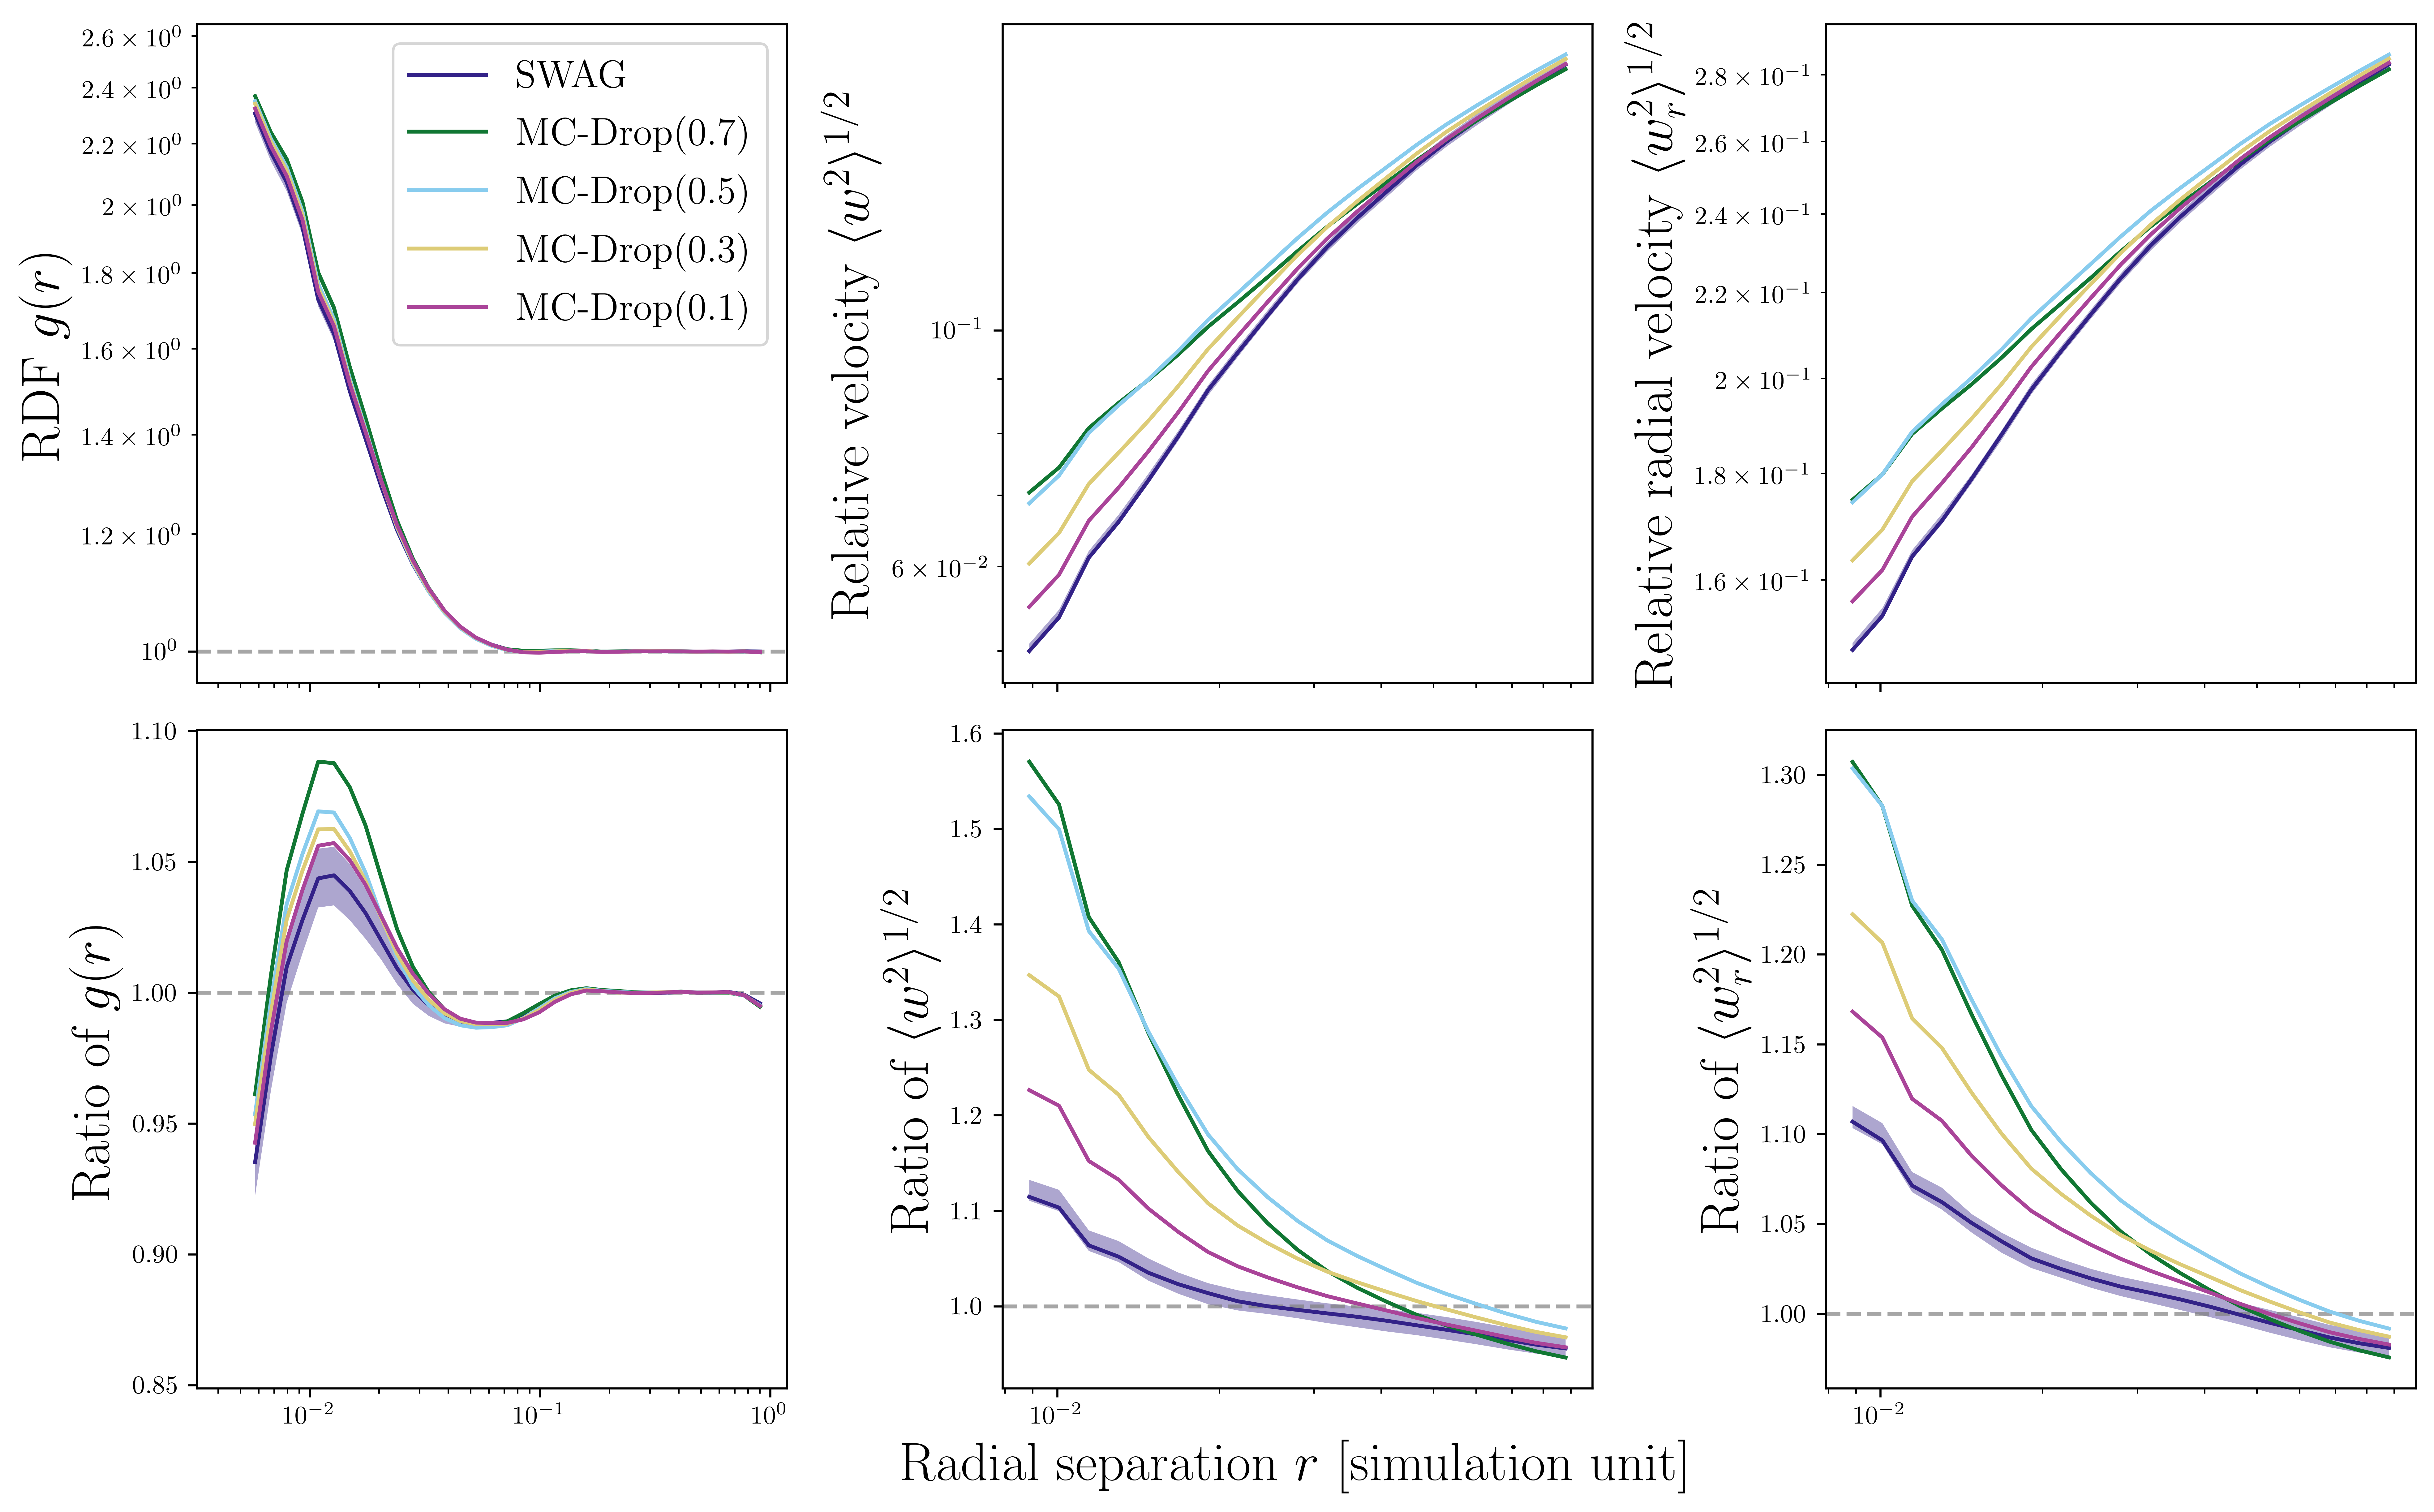

In [93]:
with PdfPages('swag_vs_mc_dropout.pdf') as pdf:
    fig, axs = plt.subplots(nrows=2,ncols=3,constrained_layout=True,sharex='col',figsize=(13,8),dpi=600)
    axs[1][0].axhline(1.0,color='grey',ls='--',alpha=0.7)
    axs[1][1].axhline(1.0,color='grey',ls='--',alpha=0.7)
    axs[1][2].axhline(1.0,color='grey',ls='--',alpha=0.7)
    axs[0][0].axhline(1.0,color='grey',ls='--',alpha=0.7)
    for i,(name, fluc, ratio) in enumerate(zip(rdf_names,rdf_fluc,rdf_ratios)):
        axs[0][0].plot(fluc['binCenters'],fluc['mean'],label=name)
        axs[0][0].fill_between(fluc['binCenters'],fluc['q1'],fluc['q3'],alpha=0.4)
        axs[1][0].plot(ratio['binCenters'],ratio['ratio_mean'],label=f'{name}/ATHENA++')
        axs[1][0].fill_between(ratio['binCenters'],ratio['ratio_q1'],ratio['ratio_q3'],alpha=0.4)
        axs[0][0].set_yscale('log')
        axs[0][0].set_xscale('log')
        #axs[0][0].legend()
        #axs[1][0].legend()

    for i,(name, fluc, ratio) in enumerate(zip(vel_names,vel_fluc,vel_ratios)):
        axs[0][1].plot(fluc['binCenters'],np.sqrt(fluc['velc_mean']),label=name)
        axs[0][1].fill_between(fluc['binCenters'],np.sqrt(fluc['velc_q1']),np.sqrt(fluc['velc_q3']),alpha=0.4)
        axs[1][1].plot(ratio['binCenters'],np.sqrt(ratio['vel_mean']),label=f'{name}/ATHENA++')
        axs[1][1].fill_between(ratio['binCenters'],np.sqrt(ratio['vel_q1']),np.sqrt(ratio['vel_q3']),alpha=0.4)
        axs[0][1].set_yscale('log')
        axs[0][1].set_xscale('log')
        #axs[0][1].legend()
        #axs[1][1].legend()

    for i,(name, fluc, ratio) in enumerate(zip(vel_names,vel_fluc,vel_ratios)):
        axs[0][2].plot(fluc['binCenters'],np.sqrt(fluc['rad_mean']),label=name)
        axs[0][2].fill_between(fluc['binCenters'],np.sqrt(fluc['rad_q1']),np.sqrt(fluc['rad_q3']),alpha=0.4)
        axs[1][2].plot(ratio['binCenters'],np.sqrt(ratio['rad_mean']),label=f'{name}/ATHENA++')
        axs[1][2].fill_between(ratio['binCenters'],np.sqrt(ratio['rad_q1']),np.sqrt(ratio['rad_q3']),alpha=0.4)
        axs[0][2].set_yscale('log')
        axs[0][2].set_xscale('log')
        #axs[0][2].legend()
        #axs[1][2].legend()
    
    [ax.xaxis.label.set_size(21) for ax in axs.flatten()]
    [ax.yaxis.label.set_size(21) for ax in axs.flatten()]
    
    axs[0][0].set_ylabel(r'RDF $g(r)$')
    #axs[1][0].set_xlabel(r'Radial separation $r$ [simulation unit]')
    axs[1][0].set_ylabel(r'Ratio of $g(r)$')

    axs[0][1].set_ylabel(r'Relative velocity $\langle w^2\rangle^{1/2}$')
    axs[1][1].set_xlabel(r'Radial separation $r$ [simulation unit]')
    axs[1][1].set_ylabel(r'Ratio of $\langle w^2\rangle^{1/2}$')

    axs[0][2].set_ylabel(r'Relative radial velocity $\langle w^2_r\rangle^{1/2}$')
    #axs[1][2].set_xlabel(r'Radial separation $r$ [simulation unit]')
    axs[1][2].set_ylabel(r'Ratio of $\langle w^2_r\rangle^{1/2}$')

    #axs[0][1].set_title('Uncertainty Estimate using SWAG and MC Dropout\n',fontsize=14)

    axs[0][0].legend(prop={'size': 15},loc='upper right')
    
    pdf.savefig(fig)

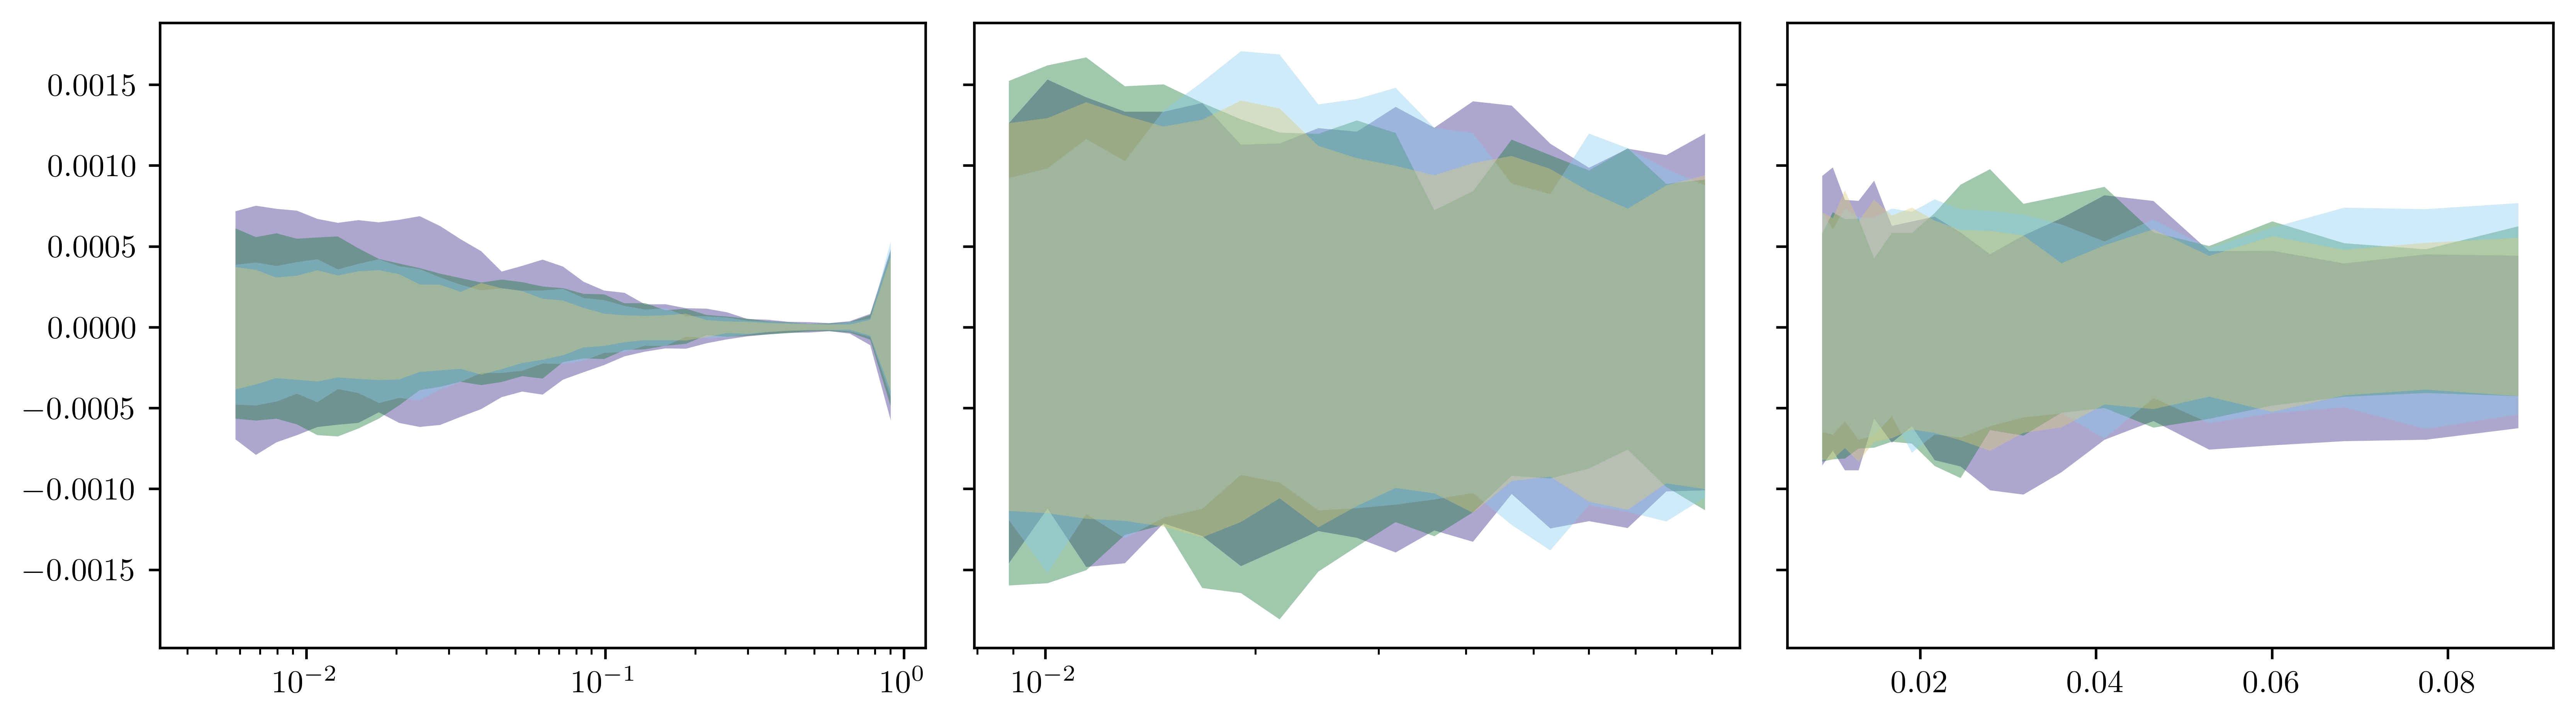

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=3,constrained_layout=True,sharex='col',sharey='row',figsize=(11,3),dpi=600)
for i,(name, fluc, ratio) in enumerate(zip(rdf_names,rdf_fluc,rdf_ratios)):
    if i == 0:
        continue
    #axs[0].plot(fluc['binCenters'],np.sqrt(fluc['var']),label=name)
    axs[0].fill_between(fluc['binCenters'],fluc['q1']/fluc['mean']-1,fluc['q3']/fluc['mean']-1,alpha=0.4)
    #axs[1][0].plot(ratio['binCenters'],ratio['ratio_mean'],label=f'{name}/ATHENA++')
    #axs[1][0].fill_between(ratio['binCenters'],ratio['ratio_q1'],ratio['ratio_q3'],alpha=0.4)
    #('symlog')
    axs[0].set_xscale('log')
    
for i,(name, fluc, ratio) in enumerate(zip(vel_names,vel_fluc,vel_ratios)):
    if i == 0:
        continue 
    #axs[1].plot(fluc['binCenters'],np.sqrt(fluc['velc_mean']),label=name)
    #axs[1].plot(fluc['binCenters'],np.sqrt(fluc['velc_var'])/np.sqrt(fluc['velc_mean']),label=name)
    #axs[1].fill_between(fluc['binCenters'],
    #                    np.sqrt(fluc['velc_q1'])/np.sqrt(fluc['velc_mean'])-1,
    #                    np.sqrt(fluc['velc_q3'])/np.sqrt(fluc['velc_mean'])-1,
    #                    alpha=0.4)
    axs[1].fill_between(ratio['binCenters'],
                        np.sqrt(ratio['vel_q1'])/np.sqrt(ratio['vel_mean'])-1,
                        np.sqrt(ratio['vel_q3'])/np.sqrt(ratio['vel_mean'])-1,
                        alpha=0.4)
    #axs[1][1].plot(ratio['binCenters'],np.sqrt(ratio['vel_mean']),label=f'{name}/ATHENA++')
    #axs[1][1].fill_between(ratio['binCenters'],np.sqrt(ratio['vel_q1']),np.sqrt(ratio['vel_q3']),alpha=0.4)
    #axs[0][1].set_yscale('log')
    axs[1].set_xscale('log')
    #axs[0][1].legend()
    #axs[1][1].legend()
    
for i,(name, fluc, ratio) in enumerate(zip(vel_names,vel_fluc,vel_ratios)):
    if i == 0:
        continue 
    #axs[1].plot(fluc['binCenters'],np.sqrt(fluc['velc_mean']),label=name)
    #axs[1].plot(fluc['binCenters'],np.sqrt(fluc['velc_var'])/np.sqrt(fluc['velc_mean']),label=name)
    axs[2].fill_between(fluc['binCenters'],np.sqrt(fluc['rad_q1'])/np.sqrt(fluc['rad_mean'])-1,np.sqrt(fluc['rad_q3'])/np.sqrt(fluc['rad_mean'])-1,alpha=0.4)
    #axs[1][1].plot(ratio['binCenters'],np.sqrt(ratio['vel_mean']),label=f'{name}/ATHENA++')
    #axs[1][1].fill_between(ratio['binCenters'],np.sqrt(ratio['vel_q1']),np.sqrt(ratio['vel_q3']),alpha=0.4)
    #axs[0][1].set_yscale('log')
    axs[1].set_xscale('log')
    #axs[0][1].legend()
    #axs[1][1].legend()
axs[0].ticklabel_format(axis='y',style='scientific')

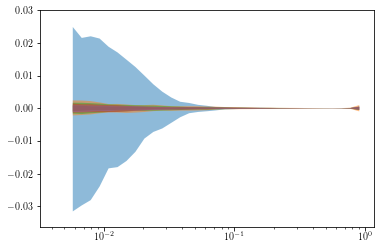

In [31]:
#plt.plot(rdf_mc01_fluc['binCenters'],rdf_mc01_fluc['mean'])
#plt.fill_between(rdf_mc01_fluc['binCenters'],rdf_mc01_fluc['q1'],rdf_mc01_fluc['q3'],alpha=0.5)

#plt.plot(rdf_mc03_fluc['binCenters'],rdf_mc03_fluc['mean'])
#plt.fill_between(rdf_mc03_fluc['binCenters'],rdf_mc03_fluc['q1'],rdf_mc03_fluc['q3'],alpha=0.5)

#plt.plot(rdf_mc05_fluc['binCenters'],rdf_mc05_fluc['mean'])


plt.fill_between(rdf_swag_fluc['binCenters'],
                 rdf_swag_fluc['q1']-rdf_swag_fluc['mean'],
                 rdf_swag_fluc['q3']-rdf_swag_fluc['mean'],alpha=0.5)
plt.fill_between(rdf_mc09_fluc['binCenters'],
                 rdf_mc09_fluc['q1']-rdf_mc09_fluc['mean'],
                 rdf_mc09_fluc['q3']-rdf_mc09_fluc['mean'],alpha=0.5)
plt.fill_between(rdf_mc07_fluc['binCenters'],
                 rdf_mc07_fluc['q1']-rdf_mc07_fluc['mean'],
                 rdf_mc07_fluc['q3']-rdf_mc07_fluc['mean'],alpha=0.5)
plt.fill_between(rdf_mc05_fluc['binCenters'],
                 rdf_mc05_fluc['q1']-rdf_mc05_fluc['mean'],
                 rdf_mc05_fluc['q3']-rdf_mc05_fluc['mean'],alpha=0.5)
plt.fill_between(rdf_mc03_fluc['binCenters'],
                 rdf_mc03_fluc['q1']-rdf_mc03_fluc['mean'],
                 rdf_mc03_fluc['q3']-rdf_mc03_fluc['mean'],alpha=0.5)
plt.fill_between(rdf_mc01_fluc['binCenters'],
                 rdf_mc01_fluc['q1']-rdf_mc01_fluc['mean'],
                 rdf_mc01_fluc['q3']-rdf_mc01_fluc['mean'],alpha=0.5)


#plt.yscale('symlog')
plt.xscale('log')

In [151]:
rdf_mc01_fluc.keys()

dict_keys(['binCenters', 'items', 'mean', 'var', 'q1', 'q3'])

NameError: name 'rdf_mc01_min_fluc' is not defined

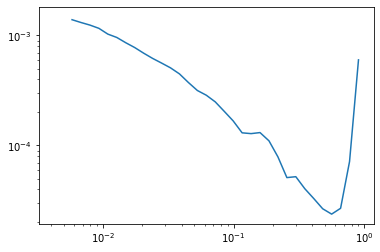

In [152]:
plt.loglog(rdf_mc01_fluc['binCenters'],np.sqrt(rdf_mc01_fluc['var']*100/99))
plt.loglog(rdf_mc01_min_fluc['binCenters'],np.sqrt(rdf_mc01_min_fluc['var']*9/8))
plt.loglog(rdf_mc01_fluc['binCenters'],np.sqrt(rdf_mc01_fluc['var']))
plt.loglog(rdf_mc01_min_fluc['binCenters'],np.sqrt(rdf_mc01_min_fluc['var']))

In [89]:
5/4

1.25

In [58]:
#valid_mc

In [ ]:
#valid_mc_p03 = []